![](https://images.pexels.com/photos/1035685/pexels-photo-1035685.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)

# Extended Kalman Filter

Kevin J. Walchko, Phd

10 May 2020

---

Here I am using an extended Kalman filter (EKF) to estimate the orientation of an inertial measurement unit (IMU). The Kalman filter is historically famous for estimating linear systems. The problem with this application is the system is not linear, but rather non-linear. Thus the *extended* Kalman filter linearizes the non-linear system at each time step by taking the Jacobian of the system equations.

## References

- Matlab: [insfilterErrorState](https://www.mathworks.com/help/fusion/ref/insfiltererrorstate.html#mw_95127457-7095-40e6-82db-ab1eeb54aa17)
- ThePoorEngineer: [Extended Kalman Filter Implementation](https://www.thepoorengineer.com/en/ekf-impl/)

## Mathematics

The system state is:

$$
X = \begin{bmatrix} q & b^g \end{bmatrix}^T
$$

where $q$ is the quaternion and $b^g$ are the biases of the gyros.

$$
q = \begin{bmatrix} q_0 & q_1 & q_2 & q_3 \end{bmatrix}^T
= \begin{bmatrix} q_r & q_x & q_y & q_z \end{bmatrix}^T
$$

The quaternion holds the orientation of the IMU. Integrating a quaterion can be accomplished in one of two ways:

$$
\dot q = \frac{1}{2} q \otimes w
$$

The first way is creating a 4x4 skew matrix using $\begin{bmatrix} 0 & \omega_b \end{bmatrix}^T$ and multiplying by the quaterion:

$$
\dot q = \frac{1}{2} S(\omega_b) q \\
S(w) =
\begin{bmatrix}
    0   & -w_x & -w_y & -w_z \\
    w_x & 0    & w_z  & -w_y \\
    w_y & -w_z & 0    & w_x \\
    w_z & w_y  & -w_x & 0
\end{bmatrix}
$$

Or a lop sided skew matrix can be created with the quaternion instead:

$$
\dot q = \frac{1}{2} S(q) \omega_b \\
S(q) =
\begin{bmatrix}
   -q_x & -q_y & -q_z \\
    q_r & -q_z &  q_y \\
    q_z &  q_r & -q_x \\
   -q_y &  q_x &  q_r
\end{bmatrix}
$$

The non-linear equations used by the extended Kalman filter are:

$$
X_{k+1} = \begin{bmatrix} q \\ b^g \end{bmatrix}_{k+1} = 
\begin{bmatrix} I_{4x4} & -\frac{T}{2} S(q) \\ 0_{3x4} & I_{3x3} \end{bmatrix}_{k}\begin{bmatrix} q \\ b^g \end{bmatrix}_{k} + 
\begin{bmatrix} \frac{T}{2} S(q) \\ 0_{3x3} \end{bmatrix}_{k} w_k
$$

where $T$ is the time step.

## Acceleration

Now the filter is trying to estimate the orientation of the IMU, which is generally the largest contributer to error in an inertial system. This can then be used to understand the orientation of the accelerometer and get better inertial reading from it. A simple model for the accellerometer is:

$$
a^b_m = b^b - R^b_w g
$$

where $a^b_m$ is the measured acceleration in the body frame, $R^b_w$ is the rotation matrix from the world frame to the body frame, $b^b$ are the additive biases and acceleration noise.

In [1]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

from the_collector import BagIt, Pickle
import os
import pandas as pd

In [2]:
def rad2deg(rad):
    return rad / np.pi * 180

def deg2rad(deg):
    return deg / 180 * np.pi

def getRotMat(q):
    c00 = q[0] ** 2 + q[1] ** 2 - q[2] ** 2 - q[3] ** 2
    c01 = 2 * (q[1] * q[2] - q[0] * q[3])
    c02 = 2 * (q[1] * q[3] + q[0] * q[2])
    c10 = 2 * (q[1] * q[2] + q[0] * q[3])
    c11 = q[0] ** 2 - q[1] ** 2 + q[2] ** 2 - q[3] ** 2
    c12 = 2 * (q[2] * q[3] - q[0] * q[1])
    c20 = 2 * (q[1] * q[3] - q[0] * q[2])
    c21 = 2 * (q[2] * q[3] + q[0] * q[1])
    c22 = q[0] ** 2 - q[1] ** 2 - q[2] ** 2 + q[3] ** 2

    rotMat = np.array([[c00, c01, c02], [c10, c11, c12], [c20, c21, c22]])
    return rotMat

def getEulerAngles(q):
    m = getRotMat(q)
    test = -m[2, 0]
    if test > 0.99999:
        yaw = 0
        pitch = np.pi / 2
        roll = np.arctan2(m[0, 1], m[0, 2])
    elif test < -0.99999:
        yaw = 0
        pitch = -np.pi / 2
        roll = np.arctan2(-m[0, 1], -m[0, 2])
    else:
        yaw = np.arctan2(m[1, 0], m[0, 0])
        pitch = np.arcsin(-m[2, 0])
        roll = np.arctan2(m[2, 1], m[2, 2])

    yaw = rad2deg(yaw)
    pitch = rad2deg(pitch)
    roll = rad2deg(roll)

    return yaw, pitch, roll

In [3]:
class EKF:
    def __init__(self):
        quaternion = np.array([1, 0, 0, 0])     # Initial estimate of the quaternion
        bias = np.array([0, 0, 0])              # Initial estimate of the gyro bias

        self.xHat = np.concatenate((quaternion, bias)).T
        self.yHatBar = np.zeros(3).transpose()
        self.p = np.identity(7) * 0.01
        self.Q = np.identity(7) * 0.001
        self.R = np.identity(6) * 0.1
        self.K = None
        self.A = None
        self.B = None
        self.C = None
        self.xHatBar = None
        self.xHatPrev = None
        self.pBar = None
        self.accelReference = np.array([0, 0, -1])
        self.magReference = np.array([0, -1, 0])
        
        # calibration parameters mag = Ax+b
#         self.mag_Ainv = np.array([[ 2.06423128e-03, -1.04778851e-04, -1.09416190e-06],
#                                   [-1.04778851e-04,  1.91693168e-03,  1.79409312e-05],
#                                   [-1.09416190e-06,  1.79409312e-05,  1.99819154e-03]])
#         self.mag_b = np.array([80.51340236, 37.08931099, 105.6731885])

        self.mag_Ainv = np.array([
            [ 1.13607723e+00,  1.42652139e-02, -1.01888869e-02],
            [ 1.42652139e-02,  1.14363401e+00, -6.29215204e-03],
            [-1.01888869e-02, -6.29215204e-03,  1.23403399e+00]])
        self.mag_Ainv = np.linalg.inv(self.mag_Ainv)
        self.mag_b = np.array([ 2.02833702e+01,  1.65255186e+01,  2.95523964e+01])

    def normalizeQuat(self, q):
        mag = (q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)**0.5
        return q / mag

    def getAccelVector(self, a):
        accel = np.array(a)
        accelMag = (accel[0] ** 2 + accel[1] ** 2 + accel[2] ** 2) ** 0.5
        return accel / accelMag

    def getMagVector(self, m):
#         magGaussRaw = np.matmul(self.mag_Ainv, np.array(m).transpose() - self.mag_b)
        magGaussRaw = np.matmul(self.mag_Ainv, np.array(m) - self.mag_b)
        magGauss_N = np.matmul(getRotMat(self.xHat), magGaussRaw)
        magGauss_N[2] = 0
        magGauss_N = magGauss_N / (magGauss_N[0] ** 2 + magGauss_N[1] ** 2) ** 0.5
        magGuass_B = np.matmul(getRotMat(self.xHat).transpose(), magGauss_N)
        return magGuass_B

    def getJacobianMatrix(self, reference):
        qHatPrev = self.xHatPrev[0:4]
        e00 = qHatPrev[0] * reference[0] + qHatPrev[3] * reference[1] - qHatPrev[2] * reference[2]
        e01 = qHatPrev[1] * reference[0] + qHatPrev[2] * reference[1] + qHatPrev[3] * reference[2]
        e02 = -qHatPrev[2] * reference[0] + qHatPrev[1] * reference[1] - qHatPrev[0] * reference[2]
        e03 = -qHatPrev[3] * reference[0] + qHatPrev[0] * reference[1] + qHatPrev[1] * reference[2]
        e10 = -qHatPrev[3] * reference[0] + qHatPrev[0] * reference[1] + qHatPrev[1] * reference[2]
        e11 = qHatPrev[2] * reference[0] - qHatPrev[1] * reference[1] + qHatPrev[0] * reference[2]
        e12 = qHatPrev[1] * reference[0] + qHatPrev[2] * reference[1] + qHatPrev[3] * reference[2]
        e13 = -qHatPrev[0] * reference[0] - qHatPrev[3] * reference[1] + qHatPrev[2] * reference[2]
        e20 = qHatPrev[2] * reference[0] - qHatPrev[1] * reference[1] + qHatPrev[0] * reference[2]
        e21 = qHatPrev[3] * reference[0] - qHatPrev[0] * reference[1] - qHatPrev[1] * reference[2]
        e22 = qHatPrev[0] * reference[0] + qHatPrev[3] * reference[1] - qHatPrev[2] * reference[2]
        e23 = qHatPrev[1] * reference[0] + qHatPrev[2] * reference[1] + qHatPrev[3] * reference[2]
        jacobianMatrix = 2 * np.array([[e00, e01, e02, e03],
                                       [e10, e11, e12, e13],
                                       [e20, e21, e22, e23]])
        return jacobianMatrix

    def predictAccelMag(self):
        # Accel
        hPrime_a = self.getJacobianMatrix(self.accelReference)
        accelBar = np.matmul(getRotMat(self.xHatBar).T, self.accelReference)
        #print(accelBar)

        # Mag
        hPrime_m = self.getJacobianMatrix(self.magReference)
        magBar = np.matmul(getRotMat(self.xHatBar).T, self.magReference)
        #print(magBar)

        tmp1 = np.concatenate((hPrime_a, np.zeros((3, 3))), axis=1)
        tmp2 = np.concatenate((hPrime_m, np.zeros((3, 3))), axis=1)
        self.C = np.concatenate((tmp1, tmp2), axis=0)

        return np.concatenate((accelBar, magBar), axis=0)

    def predict(self, w, dt):
        q = self.xHat[0:4]
        Sq = np.array([[-q[1], -q[2], -q[3]],
                       [ q[0], -q[3],  q[2]],
                       [ q[3],  q[0], -q[1]],
                       [-q[2],  q[1],  q[0]]])
        tmp1 = np.concatenate((np.identity(4), -dt / 2 * Sq), axis=1)
        tmp2 = np.concatenate((np.zeros((3, 4)), np.identity(3)), axis=1)
        self.A = np.concatenate((tmp1, tmp2), axis=0)
        self.B = np.concatenate((dt / 2 * Sq, np.zeros((3, 3))), axis=0)
        self.xHatBar = np.matmul(self.A, self.xHat) + np.matmul(self.B, np.array(w))
        self.xHatBar[0:4] = self.normalizeQuat(self.xHatBar[0:4])
        self.xHatPrev = self.xHat

        self.yHatBar = self.predictAccelMag()
        self.pBar = np.matmul(np.matmul(self.A, self.p), self.A.T) + self.Q

    def update(self, a, m):
        tmp1 = np.linalg.inv(np.matmul(np.matmul(self.C, self.pBar), self.C.T) + self.R)
        self.K = np.matmul(np.matmul(self.pBar, self.C.T), tmp1)

        magGuass_B = self.getMagVector(m)
        accel_B = self.getAccelVector(a)

        measurement = np.concatenate((accel_B, magGuass_B), axis=0)
        self.xHat = self.xHatBar + np.matmul(self.K, measurement - self.yHatBar)
        self.xHat[0:4] = self.normalizeQuat(self.xHat[0:4])
        self.p = np.matmul(np.identity(7) - np.matmul(self.K, self.C), self.pBar)

# Example

Let's read in some sensor data and run it through the filter.

In [4]:
def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')

bag = BagIt(Pickle)
# fname = "~/github/data-ins-1/2020-5-3-imu/tumble.pickle.bag"
fname = "~/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag"
# fname = "~/github/data-ins-1/2020-5-3-imu/still-y-up.pickle.bag"
# fname = os.path.expanduser(fname)

data = bag.read(fname)
bag_info(data)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
Bag keys:
--------------------------------------------------
       accel: 2001   
         mag: 2001   
        gyro: 2001   


In [5]:
def plot_rawdata(v):
    s = v[0][1]  # start time, use this as the datumn
    d = [x[0]+(x[1]-s,) for x in v]
    df = pd.DataFrame(d, columns=["x", "y", "z", "ts"])
    mx, my, mz,_ = df.mean()
    df.plot(x="ts", subplots=False, grid=True, title=f"{os.path.basename(fname)}  Mean: ({mx:.1f}, {my:.1f}, {mz:.1f})");

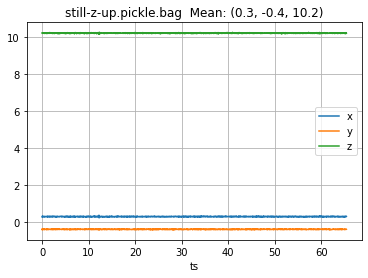

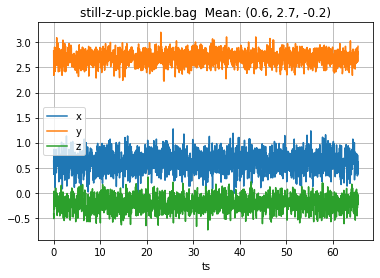

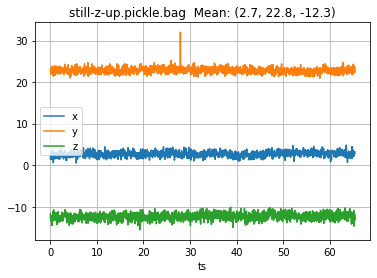

In [6]:
plot_rawdata(data["accel"])
plot_rawdata(data["gyro"])
plot_rawdata(data["mag"])

In [7]:
states = []
kf = EKF()
t = data["accel"][0][1] # grab first timestamp as the start time
for (a,ts), (m,_), (w,_) in zip(data["accel"], data["mag"], data["gyro"]):
    dt = ts - t
    t = ts
    w = [x*np.pi/180 for x in w]
    kf.predict(w, dt)
    kf.update(a, m)
    states.append((kf.xHat, ts))

In [8]:
q = [s[0][:4] for s in states]
bb = [s[0][4:] for s in states]
tt = [s[1] for s in states]
euler = list(map(getEulerAngles,q))

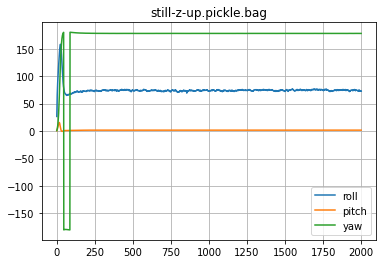

In [9]:
df = pd.DataFrame(euler, columns=["roll", "pitch", "yaw"])
df.plot(subplots=False, grid=True, title=os.path.basename(fname));

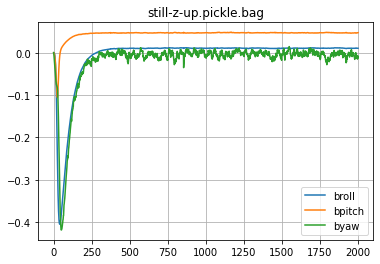

In [105]:
dfb = pd.DataFrame(bb, columns=["broll", "bpitch", "byaw"])
dfb.plot(subplots=False, grid=True, title=os.path.basename(fname));

In [53]:
np.array([80.51340236, 37.08931099, 105.6731885])

array([ 80.51340236,  37.08931099, 105.6731885 ])

In [54]:
np.array([80.51340236, 37.08931099, 105.6731885]).T

array([ 80.51340236,  37.08931099, 105.6731885 ])